In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation_new as sim

data = sklearn.datasets.load_digits()

idx = 99
# plt.imshow(data.data[idx].reshape(8, 8))

mu = data.data.mean(0, keepdims=True)
X0 = data.data - mu

I = np.eye(X0.shape[1])
alpha = 0.00001

# whiten X0
Cxx = np.cov(X0.T)
L, V = np.linalg.eigh(Cxx)
L = np.clip(L, 0, np.inf) + alpha

L_inv_sqrt = np.diag(np.sqrt(1 / L))
Mw = V @ L_inv_sqrt @ V.T

Xw0 = X0 @ Mw
Cww0 = np.cov(Xw0.T)

# W64 = fw.normalize_frame(np.random.randn(64, 64*(64+1)//2))
Lxx = np.linalg.cholesky(alpha * I + Cxx)
# g, g_all, errors, variances = sim.simulate([Lxx], W64, 0, 5000, .01, g0=None, online=False, seed=42069)

(400, 4618)


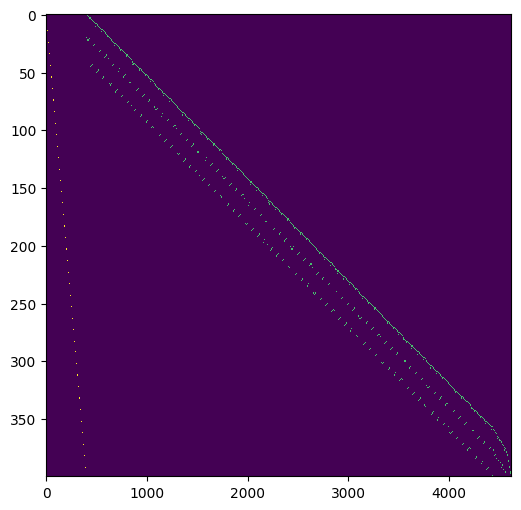

In [8]:

import itertools
def get_conv_weights(n, m, h, w):

    # n, m = 20, 20
    # h, w = 3, 3
    nm = n * m
    hw = h * w
    WI = np.zeros((nm, nm)).T

    for i in range(nm):
        WI[i, i] = 1

    idx_set = set()
    WP = []
    normalize = lambda x: x / np.linalg.norm(x)

    all_indices = list(itertools.product(range(n), range(m)))
    for i, j in all_indices:
        for k, l in all_indices:

            # get flat indices
            ij_flat = np.ravel_multi_index((i, j), (n, m))
            kl_flat = np.ravel_multi_index((k, l), (n, m))
            if (
                (i, j) != (k, l) and
                (ij_flat, kl_flat) not in idx_set and
                (kl_flat, ij_flat) not in idx_set and
                np.abs(i - k) < h and
                np.abs(j - l) < w
            ):
                idx_set.add((ij_flat, kl_flat))
                # pair (i, j) and (k, l) via flattened indices, and normalize
                wp = np.zeros(nm)
                wp[ij_flat] = 1
                wp[kl_flat] = 1
                WP.append(normalize(wp))

    WP = np.stack(WP, 0)

    W = np.concatenate([WI, WP], 0).T
    return W

W = get_conv_weights(20, 20, 3, 3)
print(W.shape)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(W, aspect="auto", interpolation="none")

In [42]:
g, g_all, errors, variances = sim.simulate([Lxx], W, 0, 5000, .01, g0=None, online=False, seed=42069, clamp=False)
M = np.linalg.inv(I + W @ np.diag(np.squeeze(g))@W.T)

g, g_all, errors, variances = sim.simulate([Lxx], W, 0, 5000, .01, g0=None, online=False, seed=42069, clamp=True)
Mnn = np.linalg.inv(I + W @ np.diag(np.squeeze(g))@W.T)

In [45]:
Xw = X0 @ M
Xwnn = X0 @ Mnn

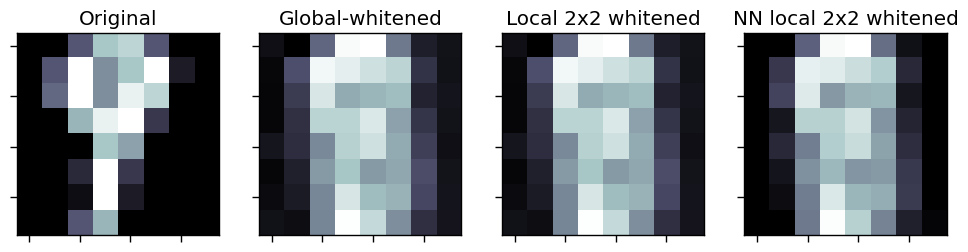

In [51]:
with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(1, 4, figsize=(12, 6), sharex="all", sharey="all")
    idx = 69
    ax[0].imshow(X0[idx].reshape(8, 8) + mu.reshape(8, 8), cmap="bone")
    ax[1].imshow(Xw[idx].reshape(8, 8) + mu.reshape(8, 8), cmap="bone")
    ax[2].imshow(Xw[idx].reshape(8, 8) + mu.reshape(8, 8), cmap="bone")
    ax[3].imshow(Xwnn[idx].reshape(8, 8) + mu.reshape(8, 8), cmap="bone")

    ax[0].set(title=f"Original", xticklabels=[], yticklabels=[])
    ax[1].set(title=f"Global-whitened")
    ax[2].set(title=f"Local {h}x{w} whitened")
    ax[3].set(title=f"NN local {h}x{w} whitened")